In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd

In [39]:
DATA_PATH="./Vowel_Data/Formant/"
n_time_sample=50

In [40]:
seed=0

In [41]:
def get_formant(file_path,max_len=n_time_sample):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    if (max_len > formant.shape[0]):
        required_rows=max_len-formant.shape[0]
        new_data=pd.DataFrame(np.zeros((required_rows,6)),columns=["time","F1","F2","F3","F4","F5"])  #empty structure to configure
        time_step=formant.iloc[1]['time']-formant.iloc[0]['time']
        new_data['time']=[formant.iloc[-1]['time']+i*time_step for i in range(1,required_rows+1)]   #new time will incremented as previous time data
        new_data.iloc[:,1:]=formant.iloc[-1,1:].values  #formant values of last existing sample is taken as new formant values
        formant=formant.append(new_data,ignore_index=True)  #new data is appended to the existing
    else:
        formant=formant.iloc[:max_len]  #truncate up to fixed length
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)
        
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    X=all_formants.drop(labels=['label'],axis=1).values
    y=all_formants['label'].values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [42]:
np.random.seed(seed)
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 252.75it/s]


In [43]:
model_v=Sequential()
model_v.add(Dense(128, activation='tanh', input_shape=(6,)))
model_v.add(Dense(64, activation='tanh'))
model_v.add(Dense(32, activation='tanh'))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [44]:
model_v.compile(
    #optimizer=opt.SGD(learning_rate=0.005,momentum=0.9),
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
history_v=model_v.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 177ms/step - loss: 2.0794 - accuracy: 0.1073 - val_loss: 1.9802 - val_accuracy: 0.2729
Epoch 2/50
1/1 [==============================] - 0s 66ms/step - loss: 1.9793 - accuracy: 0.2788 - val_loss: 1.9387 - val_accuracy: 0.1432
Epoch 3/50
1/1 [==============================] - 0s 60ms/step - loss: 1.9387 - accuracy: 0.1429 - val_loss: 1.9156 - val_accuracy: 0.1657
Epoch 4/50
1/1 [==============================] - 0s 54ms/step - loss: 1.9155 - accuracy: 0.1661 - val_loss: 1.8701 - val_accuracy: 0.1993
Epoch 5/50
1/1 [==============================] - 0s 54ms/step - loss: 1.8701 - accuracy: 0.2024 - val_loss: 1.8257 - val_accuracy: 0.2796
Epoch 6/50
1/1 [==============================] - 0s 59ms/step - loss: 1.8264 - accuracy: 0.2778 - val_loss: 1.7755 - val_accuracy: 0.2686
Epoch 7/50
1/1 [==============================] - 0s 58ms/step - loss: 1.7753 - accuracy: 0.2710 - val_loss: 1.7336 - val_accuracy: 0.2518
Epoch 8/50
1/1 [==========

In [46]:
history_dict=history_v.history

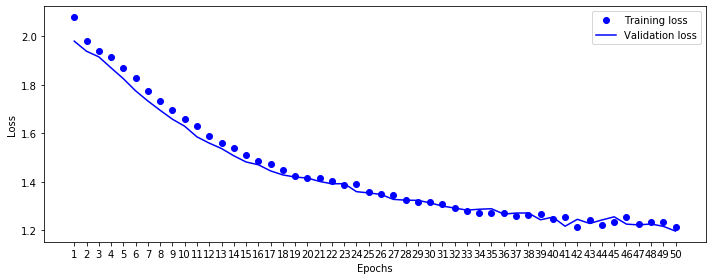

In [47]:
loss_v=history_dict['loss']
val_loss_v=history_dict['val_loss']
epochs=range(1,len(loss_v)+1)

plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'bo',label='Training loss')
plt.plot(epochs,val_loss_v,'b',label='Validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/loss_vowel_128_64_32_16_tanh_softmax_adam_batch200.svg',format='svg', dpi=600)

<Figure size 432x288 with 0 Axes>

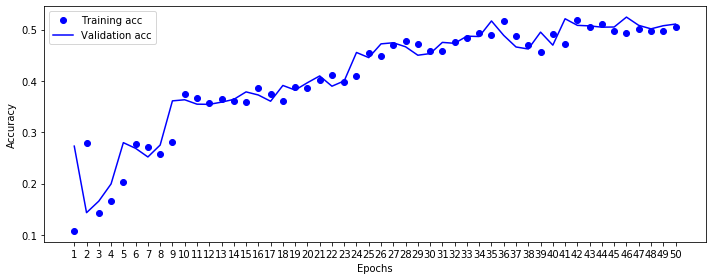

In [48]:
plt.clf()
acc_v=history_dict['accuracy']
val_acc_v=history_dict['val_accuracy']

plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'bo',label='Training acc')
plt.plot(epochs,val_acc_v,'b',label='Validation acc')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/accuracy_vowel_128_64_32_16_tanh_softmax_adam_batch200.svg',format='svg', dpi=600)

In [49]:
DATA_PATH="./Word_Data/Formant/"
n_time_sample=70

In [50]:
def get_formant(file_path,max_len=n_time_sample):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    if (max_len > formant.shape[0]):
        required_rows=max_len-formant.shape[0]
        new_data=pd.DataFrame(np.zeros((required_rows,6)),columns=["time","F1","F2","F3","F4","F5"])  #empty structure to configure
        time_step=formant.iloc[1]['time']-formant.iloc[0]['time']
        new_data['time']=[formant.iloc[-1]['time']+i*time_step for i in range(1,required_rows+1)]   #new time will incremented as previous time data
        new_data.iloc[:,1:]=formant.iloc[-1,1:].values  #formant values of last existing sample is taken as new formant values
        formant=formant.append(new_data,ignore_index=True)  #new data is appended to the existing
    else:
        formant=formant.iloc[:max_len]  #truncate up to fixed length
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)
        
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    X=all_formants.drop(labels=['label'],axis=1).values
    y=all_formants['label'].values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [51]:
np.random.seed(seed)
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 152.31it/s]


In [52]:
model_w=Sequential()
model_w.add(Dense(128, activation='tanh', input_shape=(6,)))
model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh'))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [53]:
model_w.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [54]:
history_w=model_w.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 160ms/step - loss: 2.1772 - accuracy: 0.1521 - val_loss: 2.1233 - val_accuracy: 0.1819
Epoch 2/50
1/1 [==============================] - 0s 71ms/step - loss: 2.1290 - accuracy: 0.1661 - val_loss: 2.0969 - val_accuracy: 0.1426
Epoch 3/50
1/1 [==============================] - 0s 80ms/step - loss: 2.0971 - accuracy: 0.1409 - val_loss: 1.9558 - val_accuracy: 0.1684
Epoch 4/50
1/1 [==============================] - 0s 60ms/step - loss: 1.9586 - accuracy: 0.1630 - val_loss: 1.9053 - val_accuracy: 0.1923
Epoch 5/50
1/1 [==============================] - 0s 49ms/step - loss: 1.9054 - accuracy: 0.1957 - val_loss: 1.9047 - val_accuracy: 0.1441
Epoch 6/50
1/1 [==============================] - 0s 74ms/step - loss: 1.9057 - accuracy: 0.1426 - val_loss: 1.8852 - val_accuracy: 0.1898
Epoch 7/50
1/1 [==============================] - 0s 50ms/step - loss: 1.8854 - accuracy: 0.1885 - val_loss: 1.8650 - val_accuracy: 0.1849
Epoch 8/50
1/1 [==========

In [55]:
history_dict=history_w.history

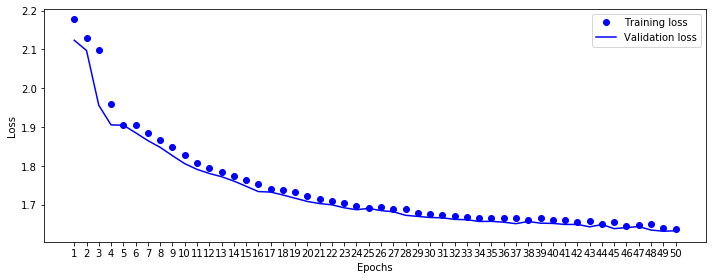

In [56]:
loss_w=history_dict['loss']
val_loss_w=history_dict['val_loss']
epochs=range(1,len(loss_v)+1)

plt.figure(figsize=(10,4))
plt.plot(epochs,loss_w,'bo',label='Training loss')
plt.plot(epochs,val_loss_w,'b',label='Validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/loss_vowel_128_64_32_16_tanh_softmax_adam_batch200.svg',format='svg', dpi=600)

<Figure size 432x288 with 0 Axes>

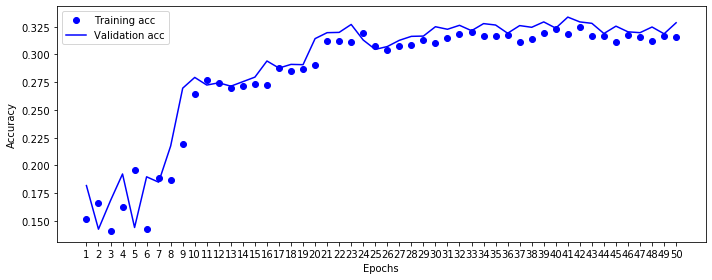

In [57]:
plt.clf()
acc_w=history_dict['accuracy']
val_acc_w=history_dict['val_accuracy']

plt.figure(figsize=(10,4))
plt.plot(epochs,acc_w,'bo',label='Training acc')
plt.plot(epochs,val_acc_w,'b',label='Validation acc')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/accuracy_vowel_128_64_32_16_tanh_softmax_adam_batch200.svg',format='svg', dpi=600)

In [58]:
#COMPARE

In [59]:
epochs=range(1,len(loss_v)+1)

In [60]:
save_specifier='fromant_128_64_32_16_tanh_softmax_adam_0.005_batchfull'

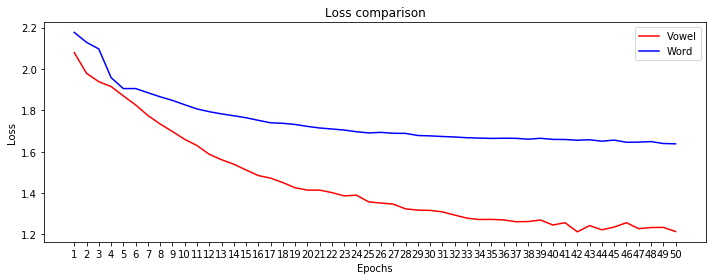

In [61]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'r',label='Vowel')
plt.plot(epochs,loss_w,'b',label='Word')
plt.title('Loss comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('./Result/New_without_CNN/loss_compare_'+save_specifier+'.svg',format='svg',dpi=600)

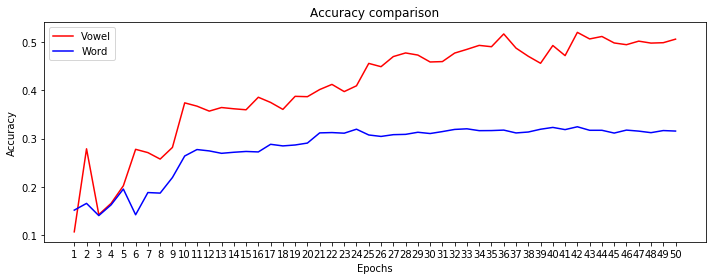

In [62]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'r',label='Vowel')
plt.plot(epochs,acc_w,'b',label='Word')
plt.title('Accuracy comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('./Result/New_without_CNN/accuracy_compate_'+save_specifier+'.svg',format='svg',dpi=600)